In [1]:
import sys 
sys.path.append('../scripts/')
from kf import *   #誤差楕円を描くのに利用

In [2]:
def make_ax(): #axisの準備
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_aspect('equal')
    ax.set_xlim(-5,5)                  
    ax.set_ylim(-5,5) 
    ax.set_xlabel("X",fontsize=10) 
    ax.set_ylabel("Y",fontsize=10)  
    return ax

def draw_trajectory(xs, ax): #軌跡の描画
    poses = [xs[s] for s in range(len(xs))]
    ax.scatter([e[0] for e in poses], [e[1] for e in poses], s=5, marker=".", color="black")
    ax.plot([e[0] for e in poses], [e[1] for e in poses], linewidth=0.5, color="black")
    
def draw_observations(xs, zlist, ax): #センサ値の描画
    for s in range(len(xs)):
        if s not in zlist:
            continue
            
        for obs in zlist[s]:
            x, y, theta = xs[s]
            ell, phi, _ = obs[1]
            mx = x + ell*math.cos(theta + phi)
            my = y + ell*math.sin(theta + phi)
            ax.plot([x,mx], [y,my], color="pink", alpha=0.5)
            
def draw_edges(edges, ax): 
    for e in edges:
        ax.plot([e.x1[0], e.x2[0]], [e.x1[1] ,e.x2[1]], color="red", alpha=0.5)

def draw(xs, zlist, edges): #edges追加
    ax = make_ax()
    draw_trajectory(xs, ax)
    draw_observations(xs, zlist, ax)
 #   draw_edges(edges, ax)
    plt.show()

In [3]:
def read_data():#データの読み込み
    hat_xs = {}     #軌跡のデータ（ステップ数をキーにして姿勢を保存）
    zlist = {} #センサ値のデータ（ステップ数をキーにして、さらにその中にランドマークのIDとセンサ値をタプルで保存）

    with open("log.txt") as f:
        for line in f.readlines():
            tmp = line.rstrip().split()

            step = int(tmp[1])
            if tmp[0] == "x": #姿勢のレコードの場合
                hat_xs[step] = np.array([float(tmp[2]), float(tmp[3]), float(tmp[4])]).T
            elif tmp[0] == "z": #センサ値のレコードの場合
                if step not in zlist:  #まだ辞書が空の時は空の辞書を作る
                    zlist[step] = []
                zlist[step].append((int(tmp[2]), np.array([float(tmp[3]), float(tmp[4]), float(tmp[5])]).T))
                
        return hat_xs, zlist

In [4]:
class Edge: ###graphbasedslam4edge
    def __init__(self, t1, t2, z1, z2, xs, sensor_noise_rate=[0.14, 0.05, 0.05]): #sensor_noise_rate追加
        assert z1[0] == z2[0] #ランドマークのIDが違ったら処理を止める
            
        self.landmark_id = z1[0]
        self.t1, self.t2 = t1, t2                   #時刻の記録
        self.x1, self.x2 = xs[t1], xs[t2]    #各時刻の姿勢
        self.z1, self.z2 = z1[1], z2[1]     #各時刻のセンサ値
        
        s1 = math.sin(self.x1[2] + self.z1[1])   #ここから以下追加
        c1 = math.cos(self.x1[2] + self.z1[1])
        s2 = math.sin(self.x2[2] + self.z2[1])
        c2 = math.cos(self.x2[2] + self.z2[1])
        
        ##誤差の計算##
        self.hat_e = self.x2 - self.x1 + np.array([
            self.z2[0]*c2 - self.z1[0]*c1, 
            self.z2[0]*s2 - self.z1[0]*s1,
            self.z2[1] - self.z2[2] - self.z1[1] + self.z1[2]
        ])
        while self.hat_e[2] >= math.pi: self.hat_e[2] -= math.pi*2
        while self.hat_e[2] <  -math.pi: self.hat_e[2] += math.pi*2
        
        ##精度行列の作成##
        Q1 = np.diag([(self.z1[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R1 = - np.array([[c1, -self.z1[0]*s1,  0],
                                     [s1,   self.z1[0]*c1, 0],
                                   [   0,                      1, -1]])
        B1 = - np.array([[1, 0, -self.z1[0]*s1], #追加
                                    [0, 1, self.z1[0]*c1],
                                    [0, 0,                       1]])
        
        Q2 = np.diag([(self.z2[0]*sensor_noise_rate[0])**2, sensor_noise_rate[1]**2, sensor_noise_rate[2]**2])
        R2 = np.array([[c2, -self.z2[0]*s2, 0],
                                  [s2, self.z2[0]*c2,   0],
                                  [  0,                      1,  -1]])
        B2 = np.array([[1, 0,  -self.z2[0]*s2], #追加
                                   [0, 1,   self.z2[0]*c2],
                                    [0, 0,                        1]])
        
        self.Sigma = R1.dot(Q1).dot(R1.T) + R2.dot(Q2).dot(R2.T)
        self.Omega = np.linalg.inv(self.Sigma)
        
        ##情報行列に足す各部分を計算##
        self.omega_upperleft = B1.T.dot(self.Omega).dot(B1)
        self.omega_upperright = B1.T.dot(self.Omega).dot(B2)
        self.omega_bottomleft = B2.T.dot(self.Omega).dot(B1)
        self.omega_bottomright = B2.T.dot(self.Omega).dot(B2)
        
        ##係数ベクトルに足す各部分を計算##
        self.xi_upper = - B1.T.dot(self.Omega).dot(self.hat_e)
        self.xi_bottom = - B2.T.dot(self.Omega).dot(self.hat_e)
        
    def __str__(self): #Omega追加
        return "landmark:{}, x1:{}, x2:{}, z1:{}, z2:{}, \nΣ:{}".format(self.landmark_id, self.x1, self.x2, self.z1, self.z2, self.Sigma) 

In [5]:
import itertools 
def make_edges(hat_xs, zlist):
    landmark_keys_zlist = {} #ランドマークのIDをキーにして観測された時刻とセンサ値を記録 

    for step in zlist:           #キーを時刻からランドマークのIDへ
        for z in zlist[step]:
            landmark_id = z[0]
            if landmark_id not in landmark_keys_zlist: 
                landmark_keys_zlist[landmark_id] = []

            landmark_keys_zlist[landmark_id].append((step, z))
    
    edges = []
    for landmark_id in landmark_keys_zlist:
        step_pairs = list(itertools.combinations(landmark_keys_zlist[landmark_id], 2)) #時刻のペアを作成
        edges += [Edge(xz1[0], xz2[0], xz1[1], xz2[1], hat_xs) for xz1, xz2 in step_pairs]
        
    return edges

In [6]:
def add_edge(edge, Omega, xi):
    f1, f2 = edge.t1*3, edge.t2*3
    t1 ,t2 = f1 + 3, f2 + 3
    Omega[f1:t1, f1:t1] += edge.omega_upperleft
    Omega[f1:t1, f2:t2] += edge.omega_upperright
    Omega[f2:t2, f1:t1] += edge.omega_bottomleft
    Omega[f2:t2, f2:t2] += edge.omega_bottomright
    xi[f1:t1] += edge.xi_upper
    xi[f2:t2] += edge.xi_bottom

<IPython.core.display.Javascript object>


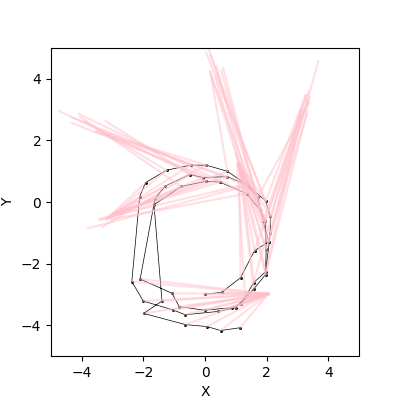

In [7]:
hat_xs, zlist = read_data() ###graphbasedslam4draw

for j in range(10):
    edges = make_edges(hat_xs, zlist)

    dim = len(hat_xs)*3
    Omega = np.zeros((dim, dim))
    xi = np.zeros(dim)

    Omega[0:3, 0:3] += np.eye(3)*1000000

    for e in edges:
        add_edge(e, Omega, xi)

    delta_xs = np.linalg.inv(Omega).dot(xi)
    for i in range(len(hat_xs)):
        a = hat_xs[i]
        a[0] += delta_xs[i*3]
        a[1] += delta_xs[i*3+1]
        a[2] += delta_xs[i*3+2]

draw(hat_xs, zlist, edges)

In [8]:
for e in edges:
    print(e)

landmark:1, x1:[ 1.35376858e-17 -3.00000000e+00 -1.94779583e-03], x2:[ 0.54802332 -2.92841455  0.4050376 ], z1:[2.04935933 0.02679605 3.07700971], z2:[ 1.50536558 -0.44356591  3.05020716], 
Σ:[[1.26624377e-01 2.08858198e-04 2.59386959e-05]
 [2.08858198e-04 1.62742047e-02 8.88208286e-03]
 [2.59386959e-05 8.88208286e-03 1.00000000e-02]]
landmark:1, x1:[ 1.35376858e-17 -3.00000000e+00 -1.94779583e-03], x2:[-2.37605916 -2.58284068  5.16005448], z1:[2.04935933 0.02679605 3.07700971], z2:[4.44677759 1.0323746  2.997741  ], 
Σ:[[ 0.46692082 -0.02949214  0.00090523]
 [-0.02949214  0.06289805  0.01619066]
 [ 0.00090523  0.01619066  0.01      ]]
landmark:1, x1:[ 1.35376858e-17 -3.00000000e+00 -1.94779583e-03], x2:[-2.00465153 -3.21641401  5.54899752], z1:[2.04935933 0.02679605 3.07700971], z2:[4.06325811 0.79095854 3.14526744], 
Σ:[[ 0.40503315  0.01713945 -0.00068082]
 [ 0.01713945  0.05265653  0.01526488]
 [-0.00068082  0.01526488  0.01      ]]
landmark:1, x1:[ 1.35376858e-17 -3.00000000e+00 -

 [-0.0079337  -0.00424845  0.01      ]]
landmark:4, x1:[ 2.11773087 -1.01924005  7.73058167], x2:[1.39562854 0.5372619  8.76483834], z1:[ 2.21139615  0.54864859 -1.11189813], z2:[ 0.76458915 -0.54788871 -1.12560945], 
Σ:[[ 0.02862885 -0.0342401  -0.00684633]
 [-0.0342401   0.09236576 -0.00290522]
 [-0.00684633 -0.00290522  0.01      ]]
landmark:4, x1:[ 2.11773087 -1.01924005  7.73058167], x2:[ 1.57800502 -2.82492753 13.40708915], z1:[ 2.21139615  0.54864859 -1.11189813], z2:[ 4.06373281  0.84595047 -1.42634325], 
Σ:[[ 0.07055482 -0.06138311 -0.0151538 ]
 [-0.06138311  0.40247794 -0.00334059]
 [-0.0151538  -0.00334059  0.01      ]]
landmark:4, x1:[ 2.11773087 -1.01924005  7.73058167], x2:[ 1.96719486 -2.35593949 13.74404573], z1:[ 2.21139615  0.54864859 -1.11189813], z2:[ 3.70014611  0.64031335 -1.32748178], 
Σ:[[ 0.07339418 -0.08499765 -0.01403985]
 [-0.08499765  0.33725375 -0.00443753]
 [-0.01403985 -0.00443753  0.01      ]]
landmark:4, x1:[ 2.11773087 -1.01924005  7.73058167], x2:[ 1

 [-0.00953572 -0.02410318  0.01      ]]
landmark:0, x1:[1.39562854 0.5372619  8.76483834], x2:[ 0.04432687  0.67481238 15.66396958], z1:[ 5.18641305  0.30290881 -0.36138012], z2:[ 5.29203666 -0.40101016 -0.33151655], 
Σ:[[ 0.9258439  -0.34175619 -0.0104162 ]
 [-0.34175619  0.28754626 -0.02400837]
 [-0.0104162  -0.02400837  0.01      ]]
landmark:0, x1:[1.39562854 0.5372619  8.76483834], x2:[-0.76661663  0.50494028 16.00133703], z1:[ 5.18641305  0.30290881 -0.36138012], z2:[ 3.99356051 -0.89564149 -0.48692888], 
Σ:[[ 0.69174712 -0.28134728 -0.01034562]
 [-0.28134728  0.25518055 -0.02029556]
 [-0.01034562 -0.02029556  0.01      ]]
landmark:0, x1:[0.71934679 0.82436882 9.04953441], x2:[-0.05367255  0.79308621  9.35466969], z1:[ 4.52376188  0.04492456 -0.25284867], z2:[ 3.36722273 -0.35183481 -0.34105044], 
Σ:[[ 0.55115769 -0.18295438 -0.0072594 ]
 [-0.18295438  0.15168    -0.01832143]
 [-0.0072594  -0.01832143  0.01      ]]
landmark:0, x1:[0.71934679 0.82436882 9.04953441], x2:[-0.49090541

In [9]:
Omega

array([[ 1.00013639e+06, -1.18355865e+02, -1.15594525e+02, ...,
        -1.15741058e+01,  7.94836068e+00,  1.07235952e+01],
       [-1.18355865e+02,  1.00129585e+06,  1.33760039e+03, ...,
         7.94836068e+00, -3.81534451e+01, -1.30355829e+01],
       [-1.15594525e+02,  1.33760039e+03,  1.00347973e+06, ...,
         7.67561029e+00, -4.80360341e+01, -1.14529606e+02],
       ...,
       [-1.15741058e+01,  7.94836068e+00,  7.67561029e+00, ...,
         4.72992697e+02, -4.22320793e+02, -4.63231129e+02],
       [ 7.94836068e+00, -3.81534451e+01, -4.80360341e+01, ...,
        -4.22320793e+02,  9.05577693e+02,  4.74989457e+02],
       [ 1.07235952e+01, -1.30355829e+01, -1.14529606e+02, ...,
        -4.63231129e+02,  4.74989457e+02,  2.51898765e+03]])